# Jagged, ragged, Awkward Arrays

# What is Awkward Array?

The previous lesson included a tricky slice:

```python
cut = muons["nMuon"] == 2

pt0 = muons["Muon_pt", cut, 0]
```

The three parts of `muons["Muon_pt", cut, 0]` slice

1. selects the `"Muon_pt"` field of all records in the array,
2. applies `cut`, a boolean array, to select only events with two muons,
3. selects the first (`0`) muon from each of those pairs. Similarly for the second (`1`) muons.

NumPy would not be able to perform such a slice, or even represent an array of variable-length lists without resorting to arrays of objects.

In [4]:
import numpy as np

# generates a ValueError
np.array([[0.0, 1.1, 2.2], [], [3.3, 4.4], [5.5], [6.6, 7.7, 8.8, 9.9]])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

Awkward Array is intended to fill this gap:

In [5]:
import awkward as ak

ak.Array([[0.0, 1.1, 2.2], [], [3.3, 4.4], [5.5], [6.6, 7.7, 8.8, 9.9]])

<Array [[0, 1.1, 2.2], [], ..., [6.6, 7.7, 8.8, 9.9]] type='5 * var * float64'>

Arrays like this are sometimes called "[jagged arrays](https://en.wikipedia.org/wiki/Jagged_array)" and sometimes "ragged arrays."

## Slicing in Awkward Array

Basic slices are a generalization of NumPy's—what NumPy would do if it had variable-length lists.

In [ ]:
array = ak.Array([[0.0, 1.1, 2.2], [], [3.3, 4.4], [5.5], [6.6, 7.7, 8.8, 9.9]])
array.tolist()

In [ ]:
array[2]

In [ ]:
array[-1, 1]

In [ ]:
array[2:, 0]

In [ ]:
array[2:, 1:]

In [ ]:
array[:, 0]

**Quick quiz:** why does the last one raise an error?

Boolean and integer slices work, too:

In [ ]:
array[[True, False, True, False, True]]

In [ ]:
array[[2, 3, 3, 1]]

Like NumPy, boolean arrays for slices can be computed, and functions like [ak.num](https://awkward-array.readthedocs.io/en/latest/_auto/ak.num.html) are helpful for that.

In [ ]:
ak.num(array)

In [ ]:
ak.num(array) > 0

In [ ]:
array[ak.num(array) > 0, 0]

In [ ]:
array[ak.num(array) > 1, 1]

Now consider this (similar to an example from the first lesson):

In [ ]:
cut = array * 10 % 2 == 0

array[cut]

This array, `cut`, is not just an array of booleans. It's a jagged array of booleans. All of its nested lists fit into `array`'s nested lists, so it can deeply select numbers, rather than selecting lists.

## Application: selecting particles, rather than events

Returning to the big TTree from the previous lesson,

In [1]:
import uproot

file = uproot.open(
    "root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root"
)
tree = file["Events"]

muon_pt = tree["Muon_pt"].array(entry_stop=10)

This jagged array of booleans selects all *muons* with at least 20 GeV:

In [2]:
particle_cut = muon_pt > 20

muon_pt[particle_cut]

<Array [[], [], [], [], ..., [...], [23.9], [], []] type='10 * var * float32'>

and this non-jagged array of booleans (made with [ak.any](https://awkward-array.readthedocs.io/en/latest/_auto/ak.any.html)) selects all events *that have* a muon with at least 20 GeV:

In [8]:
event_cut = ak.any(muon_pt > 20, axis=1)
event_cut = ak.max(muon_pt, axis=1)>20

cleaned = muon_pt[particle_cut]
final_muons = cleaned[event_cut]

**Quick quiz:** construct exactly the same `event_cut` using [ak.max](https://awkward-array.readthedocs.io/en/latest/_auto/ak.max.html).

**Quick quiz:** apply both cuts; that is, select muons with over 20 GeV from events that have them.

Hint: you'll want to make a

```python
cleaned = muon_pt[particle_cut]
```

intermediary and you can't use the variable `event_cut`, as-is.


Hint: the final result should be a jagged array, just like muon_pt, but with fewer lists and fewer items in those lists.

````{note}
:class: dropdown
## Solution (no peeking!)

```python
cleaned = muon_pt[particle_cut]
final_result = cleaned[event_cut]
```
````

# Combinatorics in Awkward Array

Variable-length lists present more problems than just slicing and computing formulas array-at-a-time. Often, we want to combine particles in all possible pairs (within each event) to look for decay chains.

## Pairs from two arrays, pairs from a single array

Awkward Array has functions that generate these combinations. For instance, [ak.cartesian](https://awkward-array.readthedocs.io/en/latest/_auto/ak.cartesian.html) takes a Cartesian product per event (when `axis=1`, the default).

![cartoon-cartesian](img/cartoon-cartesian.png)

In [12]:
numbers = ak.Array([[1, 2, 3], [], [5, 7], [11]])
letters = ak.Array([["a", "b"], ["c"], ["d"], ["e", "f"]])

pairs = ak.cartesian((numbers, letters))
print(pairs)

[[(1, 'a'), (1, 'b'), (2, 'a'), (2, 'b'), (3, 'a'), (3, 'b')], [], ..., [...]]


These `pairs` are 2-tuples, which are like records in how they're sliced out of an array: using strings.

In [10]:
pairs["0"]

<Array [[1, 1, 2, 2, 3, 3], [], [5, ...], [11, 11]] type='4 * var * int64'>

In [11]:
pairs["1"]

<Array [['a', 'b', 'a', 'b', 'a', 'b'], [], ..., [...]] type='4 * var * string'>

There's also [ak.unzip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.unzip.html), which extracts every field into a separate array (opposite of [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html)).

In [13]:
lefts, rights = ak.unzip(pairs)
lefts

<Array [[1, 1, 2, 2, 3, 3], [], [5, ...], [11, 11]] type='4 * var * int64'>

In [14]:
rights

<Array [['a', 'b', 'a', 'b', 'a', 'b'], [], ..., [...]] type='4 * var * string'>

Note that these `lefts` and `rights` are not the original `numbers` and `letters`: they have been duplicated and have the same shape.

The Cartesian product is equivalent to this C++ `for` loop over two collections:

```cpp
for (int i = 0; i < numbers.size(); i++) {
  for (int j = 0; j < letters.size(); j++) {
    // compute formula with numbers[i] and letters[j]
  }
}
```

Sometimes, though, we want to find all pairs within a single collection, without repetition. That would be equivalent to this C++ `for` loop:

```cpp
for (int i = 0; i < numbers.size(); i++) {
  for (int j = i + 1; i < numbers.size(); j++) {
    // compute formula with numbers[i] and numbers[j]
  }
}
```

The Awkward function for this case is [ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html).

![cartoon-combinations](img/cartoon-combinations.png)

In [16]:
pairs = ak.combinations(numbers, 2)
print(pairs)

lefts, rights = ak.unzip(pairs)

lefts * rights  # they line up, so we can compute formulas

[[(1, 2), (1, 3), (2, 3)], [], [(5, 7)], []]


<Array [[2, 3, 6], [], [35], []] type='4 * var * int64'>

## Application to dimuons

The dimuon search in the previous lesson was a little naive in that we required *exactly two* muons to exist in every event and only computed the mass of that combination. If a third muon were present because it's a complex electroweak decay or because something was mismeasured, we would be blind to the other two muons. They might be real dimuons.

A better procedure would be to look for all pairs of muons in an event and apply some criteria for selecting them.

In this example, we'll [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html) the muon variables together into records.

In [1]:
import uproot
import awkward as ak

file = uproot.open(
    "root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root"
)
tree = file["Events"]

arrays = tree.arrays(filter_name="/Muon_(pt|eta|phi|charge)/", entry_stop=10000)

muons = ak.zip(
    {
        "pt": arrays["Muon_pt"],
        "eta": arrays["Muon_eta"],
        "phi": arrays["Muon_phi"],
        "charge": arrays["Muon_charge"],
    }
)

In [2]:
arrays.type

ArrayType(RecordType([ListType(NumpyType('float32')), ListType(NumpyType('float32')), ListType(NumpyType('float32')), ListType(NumpyType('int32'))], ['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_charge']), 10000, None)

In [3]:
muons.type

ArrayType(ListType(RecordType([NumpyType('float32'), NumpyType('float32'), NumpyType('float32'), NumpyType('int32')], ['pt', 'eta', 'phi', 'charge'])), 10000, None)

The difference between `arrays` and `muons` is that `arrays` contains separate lists of `"Muon_pt"`, `"Muon_eta"`, `"Muon_phi"`, `"Muon_charge"`, while `muons` contains lists of records with `"pt"`, `"eta"`, `"phi"`, `"charge"` fields.

Now we can compute pairs of muon *objects*

In [4]:
pairs = ak.combinations(muons, 2)

pairs.type

ArrayType(ListType(RecordType([RecordType([NumpyType('float32'), NumpyType('float32'), NumpyType('float32'), NumpyType('int32')], ['pt', 'eta', 'phi', 'charge']), RecordType([NumpyType('float32'), NumpyType('float32'), NumpyType('float32'), NumpyType('int32')], ['pt', 'eta', 'phi', 'charge'])], None)), 10000, None)

and separate them into arrays of the first muon and the second muon in each pair.

In [5]:
mu1, mu2 = ak.unzip(pairs)

**Quick quiz:** how would you ensure that all lists of records in `mu1` and `mu2` have the same lengths? Hint: see [ak.num](https://awkward-array.readthedocs.io/en/latest/_auto/ak.num.html) and [ak.all](https://awkward-array.readthedocs.io/en/latest/_auto/ak.all.html).

Since they do have the same lengths, we can use them in a formula.

In [8]:
import numpy as np

mass = np.sqrt(
    2 * mu1.pt * mu2.pt * (np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))
)
print(mass.type)

10000 * var * float32


**Quick quiz:** how many masses do we have in each event? How does this compare with `muons`, `mu1`, and `mu2`?

## Plotting the jagged array

Since this `mass` is a jagged array, it can't be directly histogrammed. Histograms take a set of *numbers* as inputs, but this array contains *lists*.

Supposing you just want to plot the numbers from the lists, you can use [ak.flatten](https://awkward-array.readthedocs.io/en/latest/_auto/ak.flatten.html) to flatten one level of list or [ak.ravel](https://awkward-array.readthedocs.io/en/latest/_auto/ak.ravel.html) to flatten all levels.

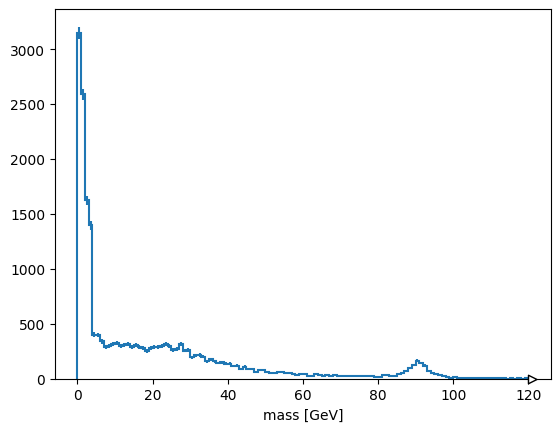

In [9]:
import hist

hist.Hist(hist.axis.Regular(120, 0, 120, label="mass [GeV]")).fill(
    ak.ravel(mass)
).plot();

Alternatively, suppose you want to plot the *maximum* mass-candidate in each event, biasing it toward Z bosons? [ak.max](https://awkward-array.readthedocs.io/en/latest/_auto/ak.max.html) is a different function that picks one element from each list, when used with `axis=1`.

In [10]:
ak.max(mass, axis=1)

<Array [34.4, 27.9, None, 26.2, ..., 42.9, 0.252, 93.4] type='10000 * ?float32'>

Some values are `None` because there is no maximum of an empty list. [ak.flatten](https://awkward-array.readthedocs.io/en/latest/_auto/ak.flatten.html)/[ak.ravel](https://awkward-array.readthedocs.io/en/latest/_auto/ak.ravel.html) remove missing values (`None`) as well as squashing lists,

In [11]:
ak.flatten(ak.max(mass, axis=1), axis=0)

<Array [34.4, 27.9, 26.2, 18.2, ..., 42.9, 0.252, 93.4] type='8880 * float32'>

but so does removing the empty lists in the first place.

In [12]:
ak.max(mass[ak.num(mass) > 0], axis=1)

<Array [34.4, 27.9, 26.2, 18.2, ..., 42.9, 0.252, 93.4] type='8880 * ?float32'>

`````{tip} 
## Exercise: select pairs of muons with opposite charges

This is neither an event-level cut nor a particle-level cut, it is a cut on particle *pairs*.

````{note}
:class: dropdown
## Solution (no peeking!)
The `mu1` and `mu2` variables are the left and right halves of muon pairs. Therefore,

```python
cut = (mu1.charge != mu2.charge)
```
has the right multiplicity to be applied to the `mass` array.

```python
hist.Hist(hist.axis.Regular(120, 0, 120, label="mass [GeV]")).fill(
    ak.ravel(mass[cut])
).plot()
```
plots the cleaned muon pairs.
````
`````

`````{tip} 
## Exercise (harder): plot the one mass candidate per event that is strictly closest to the Z mass

Instead of just taking the maximum mass in each event, find the one with the minimum difference between computed mass and `zmass = 91`.

Hint: use [ak.argmin](https://awkward-array.readthedocs.io/en/latest/_auto/ak.argmin.html) with `keepdims=True`.

Anticipating one of the future lessons, you could get a more accurate mass by asking the Particle library:

```python
import particle, hepunits

zmass = particle.Particle.findall("Z0")[0].mass / hepunits.GeV
```

````{note}
:class: dropdown
## Solution (no peeking!)

Instead of maximizing `mass`, we want to minimize `abs(mass - zmass)` and apply that choice to `mass`. [ak.argmin](https://awkward-array.readthedocs.io/en/latest/_auto/ak.argmin.html) returns the *index position* of this minimum difference, which we can then apply to the original `mass`. However, without `keepdims=True`, [ak.argmin](https://awkward-array.readthedocs.io/en/latest/_auto/ak.argmin.html) removes the dimension we would need for this array to have the same nested shape as `mass`. Therefore, we `keepdims=True` and then use [ak.ravel](https://awkward-array.readthedocs.io/en/latest/_auto/ak.ravel.html) to get rid of missing values and flatten lists.

The last step would require two applications of [ak.flatten](https://awkward-array.readthedocs.io/en/latest/_auto/ak.flatten.html): one for squashing lists at the first level and another for removing `None` at the second level.

```python
which = ak.argmin(abs(mass - zmass), axis=1, keepdims=True)

hist.Hist(hist.axis.Regular(120, 0, 120, label="mass [GeV]")).fill(
    ak.ravel(mass[which])
).plot();
```
````
`````

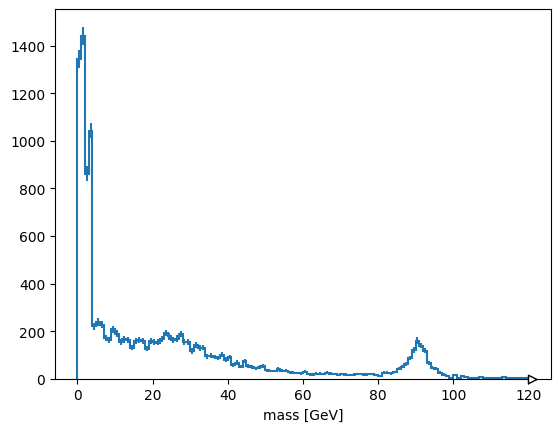

In [13]:
#Plotting muons with opposite charge:
opposite_charge_cut = (mu1.charge != mu2.charge)

hist.Hist(hist.axis.Regular(120, 0, 120, label="mass [GeV]")).fill(
    ak.ravel(mass[opposite_charge_cut])
).plot();


[27.9, 18.2, 4.52, 114, 1.57, 23.7, ..., 3.05, 2.2, 24.2, 42.9, 0.252, 93.4]


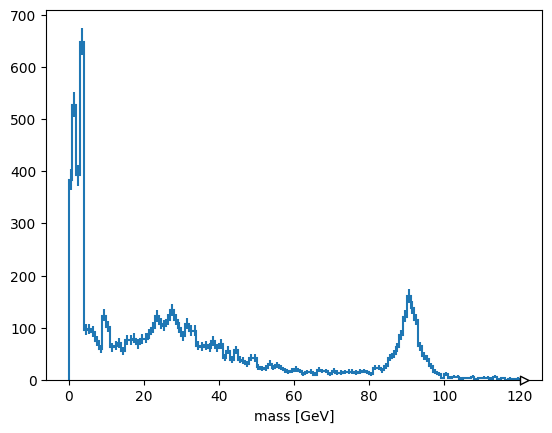

In [33]:

z_mass = 91
#Plotting muon pairs which are closest to Z-peak:

cleaned_mass = mass[opposite_charge_cut]
z_muons_cut = ak.argmin(abs(cleaned_mass-z_mass), axis=1, keepdims = True)
z_muons = cleaned_mass[ak.flatten(z_muons_cut, axis=0)]
print(ak.flatten(z_muons, axis=None))

hist.Hist(hist.axis.Regular(120, 0, 120, label="mass [GeV]")).fill(
    ak.flatten(z_muons, axis=None)
).plot();